# Image classification using logistic regression in PyTorch

## Working with Images
The dataset used is [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/), consisting of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. 

Some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

To work with images, the torchvision library is used. It contains some utilities for working with image data, and provides helper classes to download and import popular datasets, like MNIST, automatically

In [2]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
# Download training dataset
dataset = MNIST(
    root='data/', 
    download=True,
    train=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



Check the dataset size

In [4]:
len(dataset)

60000

Now download the test set

In [7]:
# Download test dataset
test_dataset = MNIST(
    root='data/', 
    download=True,
    train=False
)
len(test_dataset)

10000

Consider one image

In [8]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

Each element of dataset is a pair, consisting of a 28x28px image and a label. 

The image is an object of the class `PIL.Image.Image`, part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). It is possible to visualize the images using [`matplotlib`](https://matplotlib.org/).

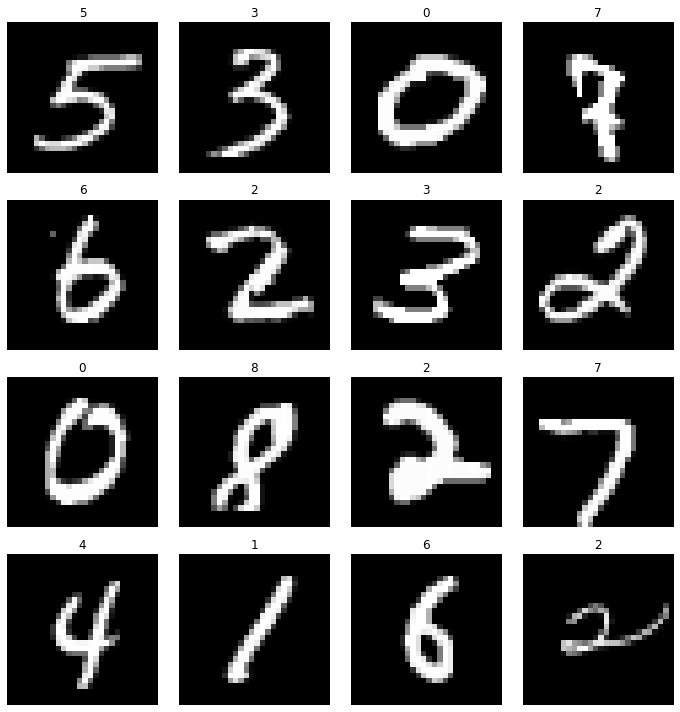

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = dataset[0]


# plt.imshow(image, cmap='gray')
# plt.title(f'label: {label}')

figure = plt.figure(figsize=(10,10))
cols, rows = 4, 4
for pos in range(1,cols*rows+1):
    id_sample = torch.randint(len(dataset),size=(1,)).item()
    image, label = dataset[id_sample]
    figure.add_subplot(rows, cols, pos)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(str(label))
    plt.tight_layout()
plt.show()

## From images to tensors
Images has to be converted to tensors so that PyTorch can work on them.

This can be done using the `transforms` module of torchvision

In [25]:
import torchvision.transforms as transforms

The trasformation is performed during the import of the image dataset

In [27]:
dataset = MNIST(
    root='/data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\train-images-idx3-ubyte.gz to /data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\train-labels-idx1-ubyte.gz to /data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\t10k-images-idx3-ubyte.gz to /data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\t10k-labels-idx1-ubyte.gz to /data\MNIST\raw



In [29]:
img_tensor, label = dataset[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

The image is now converted to a 1x28x28 tensor. 
- The first dimension tracks color channels. 
- The second and third dimensions represent pixels along the height and width of the image, respectively. 

Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB). 

The values in the image tensor range from 0 to 1, with `0` representing black, `1` white, and the values in between different shades of grey

## Training and Validation Datasets
The dataset is split into
1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model
3. **Test set** - used to compare different models or approaches and report the model's final accuracy

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models results against the same collection of images. 

There's no predefined validation set, so the training set must manually split the 60,000 images into training and validation datasets. This can be done using the `random_spilt` method.